In [ ]:
! pip install datasets
! pip install bertopic
! pip install seaborn
! pip install xgboost
! pip install nltk
! pip install langdetect
! pip install fasttext


In [17]:
! wget -nc https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz


--2025-02-02 12:58:54--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.66, 3.167.112.51, 3.167.112.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz’

lid.176.ftz         100%[===================>] 916.03K  --.-KB/s    in 0.006s  

2025-02-02 12:58:54 (159 MB/s) - ‘lid.176.ftz’ saved [938013/938013]



In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
from datasets import load_dataset

# dataset_name = "REILX/cleaned-lmsys-arena-human-preference-55k"
dataset_name ="lmsys/lmsys-arena-human-preference-55k"
# dataset_name = ("lmsys/lmsys-chat-1m"
ds = load_dataset(dataset_name, token="hugging_face_tokens")
ds.shape

{'train': (57477, 9)}

In [5]:
import pandas as pd

train_dataset = ds["train"]
df =train_dataset.to_pandas()
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [3]:
# how sample convo looks like

df.iloc[:1].to_dict()

{'id': {0: 30192},
 'model_a': {0: 'gpt-4-1106-preview'},
 'model_b': {0: 'gpt-4-0613'},
 'prompt': {0: '["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]'},
 'response_a': {0: '["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\\n\\nHere are some arguments in favor of and against such policies:\\n\\n**Arguments in favor:**\\n\\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\\n\\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from bertopic import BERTopic
from transformers import pipeline
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punkt')
# nltk.download('punkt_tab')

In [5]:
# Data Preprocessing
def preprocess_data(df):
    # Function to safely extract text from string representation of list
    def safe_extract_text(x):
        try:
            return eval(x)[0] if pd.notna(x) else ""
        except:
            return ""

    # Extract text from prompt and response columns
    df['prompt_text'] = df['prompt'].apply(safe_extract_text)
    df['response_a_text'] = df['response_a'].apply(safe_extract_text)
    df['response_b_text'] = df['response_b'].apply(safe_extract_text)
    
    # Function to safely calculate length
    def safe_len(x):
        return len(x) if pd.notna(x) else 0

    # Calculate text features
    df['prompt_length'] = df['prompt_text'].apply(safe_len)
    df['response_a_length'] = df['response_a_text'].apply(safe_len)
    df['response_b_length'] = df['response_b_text'].apply(safe_len)
    
    # Function to safely count words
    def safe_word_count(x):
        return len(word_tokenize(x)) if pd.notna(x) and x != "" else 0

    df['prompt_word_count'] = df['prompt_text'].apply(safe_word_count)
    df['response_a_word_count'] = df['response_a_text'].apply(safe_word_count)
    df['response_b_word_count'] = df['response_b_text'].apply(safe_word_count)
    
    # Function to safely count sentences
    def safe_sentence_count(x):
        return len(sent_tokenize(x)) if pd.notna(x) and x != "" else 0

    df['prompt_sentence_count'] = df['prompt_text'].apply(safe_sentence_count)
    df['response_a_sentence_count'] = df['response_a_text'].apply(safe_sentence_count)
    df['response_b_sentence_count'] = df['response_b_text'].apply(safe_sentence_count)
    
    # Calculate average sentence length, handling division by zero
    df['prompt_avg_sentence_length'] = df.apply(lambda row: row['prompt_length'] / row['prompt_sentence_count'] if row['prompt_sentence_count'] > 0 else 0, axis=1)
    df['response_a_avg_sentence_length'] = df.apply(lambda row: row['response_a_length'] / row['response_a_sentence_count'] if row['response_a_sentence_count'] > 0 else 0, axis=1)
    df['response_b_avg_sentence_length'] = df.apply(lambda row: row['response_b_length'] / row['response_b_sentence_count'] if row['response_b_sentence_count'] > 0 else 0, axis=1)
    
    return df

df = preprocess_data(df)

In [9]:
import pickle
with open("raw_processed_train_lmsys-arena-human-preference-55k_dataset.pkl", mode="wb") as f:
    pickle.dump(df, f)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# import xgboost as xgb
from bertopic import BERTopic
from transformers import pipeline
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import pickle 
with  open("raw_processed_train_lmsys-arena-human-preference-55k_dataset.pkl",'rb') as pck_file:
    df = pickle.load(pck_file)

In [34]:
def plot_model_distribution(df):
    models = pd.concat([df['model_a'], df['model_b']]).value_counts()
    plt.figure(figsize=(20, 6))
    sns.barplot(x=models.index, y=models.values)
    plt.title('Distribution of Models in the Dataset')
    plt.xlabel('Model')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

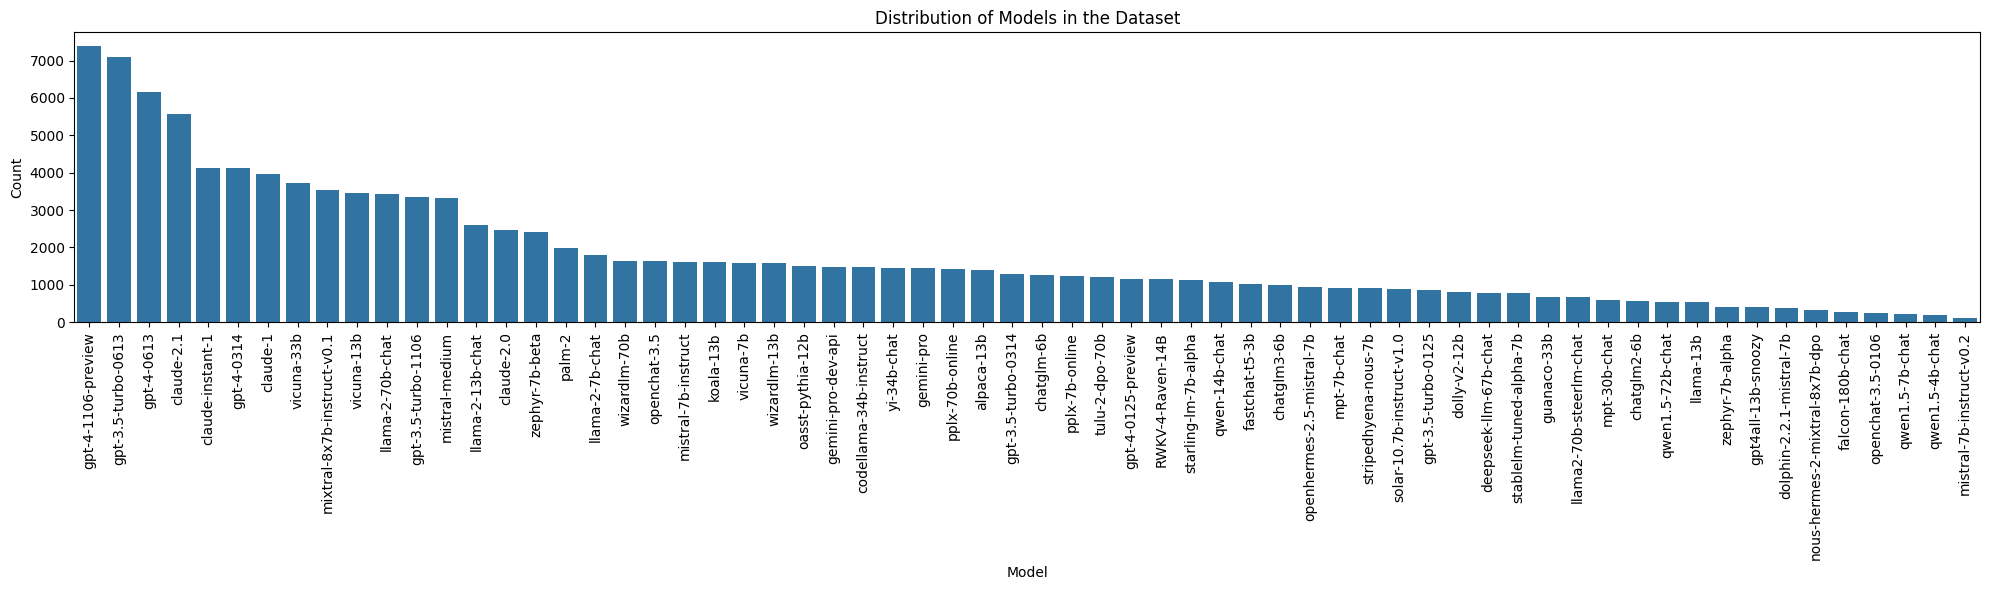

In [35]:

plot_model_distribution(df)

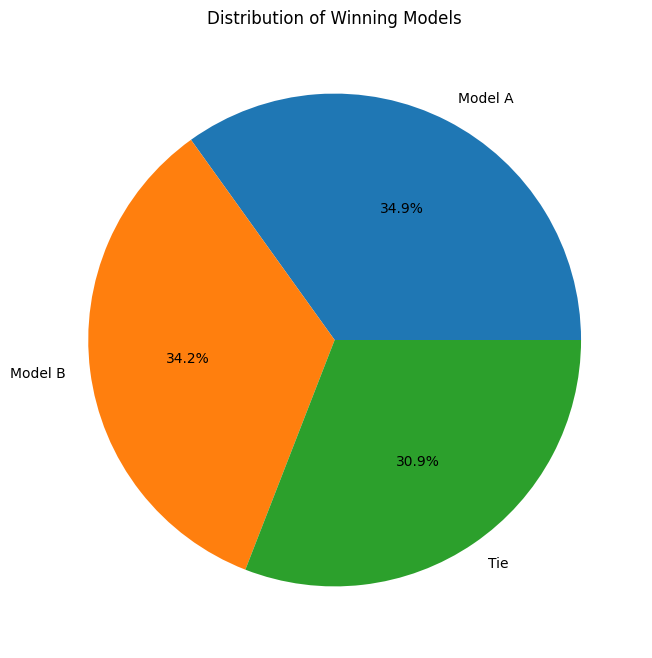

In [8]:
def plot_winner_distribution(df):
    winners = df[['winner_model_a', 'winner_model_b', 'winner_tie']].sum()
    plt.figure(figsize=(8, 8))
    plt.pie(winners, labels=['Model A', 'Model B', 'Tie'], autopct='%1.1f%%')
    plt.title('Distribution of Winning Models')
    plt.show()

plot_winner_distribution(df)

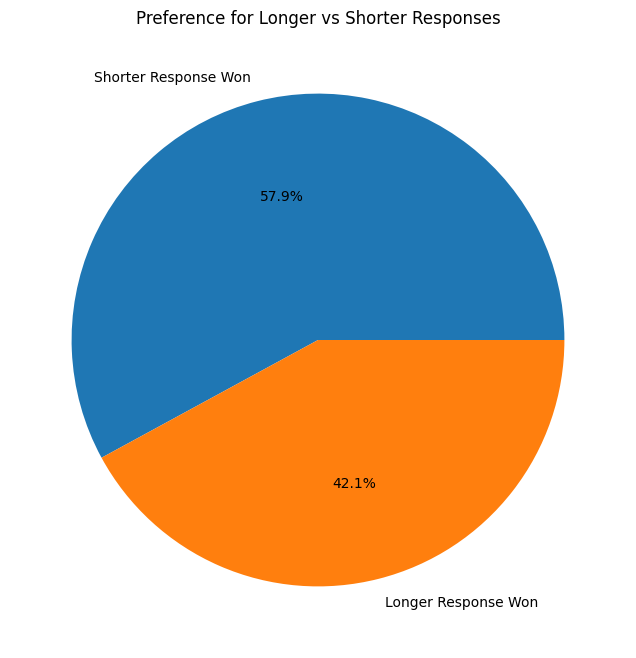

In [10]:
def plot_length_preference(df):
    df['longer_response_won'] = ((df['response_a_length'] > df['response_b_length']) & (df['winner_model_a'] == 1)) | \
                                ((df['response_b_length'] > df['response_a_length']) & (df['winner_model_b'] == 1))
    preference = df['longer_response_won'].value_counts(normalize=True)
    plt.figure(figsize=(8, 8))
    plt.pie(preference, labels=['Shorter Response Won', 'Longer Response Won'], autopct='%1.1f%%')
    plt.title('Preference for Longer vs Shorter Responses')
    plt.show()

plot_length_preference(df)

In [8]:
import re
import fasttext
import pandas as pd

# Load fastText language identification model
ft_model = fasttext.load_model('lid.176.ftz')

# Clean text function
def clean_text(text):
    try:
        text = re.sub(r'[\n\t\r]', ' ', text)                   # Remove newlines/tabs
        text = re.sub(r'\\+', '', text)                        # Remove backslashes
        text = re.sub(r'[^\x00-\x7F]+', '', text)              # Remove non-ASCII characters (emojis, symbols)
        text = re.sub(r'\s+', ' ', text).strip()               # Remove extra spaces
        return text                                  # Limit to 1000 characters
    except:
        return ''

# Detect English
def is_english_fasttext(text):
    try:
        text = clean_text(text)
        lang = ft_model.predict(text)[0][0].replace('__label__', '')
        return lang == 'en'
    except:
        return False
        
# Apply language detection efficiently
def df_sampling(df, sample_size=50000):
    print("Filtering for English text only...")

    # Sample data
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

    # Clean and prepare text
    df_sample['prompt_text'] = df_sample['prompt_text'].fillna('').astype(str)
    df_sample['prompt_text'] = df_sample['prompt_text'].apply(clean_text)

    # Batch processing
    batch_size = 5000
    mask = []
    for start in range(0, len(df_sample), batch_size):
        batch = df_sample['prompt_text'].iloc[start:start+batch_size]
        languages = [is_english_fasttext(text) for text in batch]
        mask.extend(languages)

    # Filter English text
    df_sample = df_sample[mask]
    print(f"Retained {len(df_sample)} English rows.")
    return df_sample
# Perform topic modeling on a subset of the data
sample_size = df.shape[0] -1  # Adjust this based on your computational resources
num_topics = 10  # Adjust the number of topics as needed
df_sample = df_sampling(df, sample_size)

df_sample

Filtering for English text only...


Retained 56295 English rows.


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_text,...,response_b_length,prompt_word_count,response_a_word_count,response_b_word_count,prompt_sentence_count,response_a_sentence_count,response_b_sentence_count,prompt_avg_sentence_length,response_a_avg_sentence_length,response_b_avg_sentence_length
37379,2785062085,gpt-3.5-turbo-0613,codellama-34b-instruct,"[""what does hello world mean""]","[""\""Hello, World!\"" is a phrase used in comput...","[""\""Hello, World!\"" is a common phrase used to...",1,0,0,what does hello world mean,...,334,5,83,70,1,6,5,26.000000,71.666667,66.800000
644,48259531,mistral-medium,gpt-4-0314,"[""I ran a marathon in 3:12:00 weighting 84kg. ...","[""It's difficult to provide an exact answer to...","[""To accurately estimate how much faster you w...",1,0,0,I ran a marathon in 3:12:00 weighting 84kg. Ho...,...,1384,19,185,290,2,7,6,40.500000,145.571429,230.666667
48496,3622731894,gpt-4-0314,gpt-3.5-turbo-0314,"[""Below is an instruction that describes a tas...","[""\u8fd9\u6b3e\u7eaf\u8272\u4e94\u5206\u88e4\u...","[""\u6839\u636e\u63d0\u4f9b\u7684\u4ea7\u54c1\u...",0,0,1,"Below is an instruction that describes a task,...",...,127,85,1,2,3,1,1,98.666667,86.000000,127.000000
12603,933663766,openchat-3.5,gpt-3.5-turbo-0613,"[""How do I run static analysis with gcc in QT ...","[""To run static analysis with gcc in QT Creato...","[""To run static analysis with gcc in QT Creato...",1,0,0,How do I run static analysis with gcc in QT Cr...,...,1035,12,375,234,1,30,19,52.000000,51.833333,54.473684
16697,1246768370,codellama-34b-instruct,mixtral-8x7b-instruct-v0.1,"[""What did the music producer \u00d8fdream die...","[""I am not able to provide information on the ...","[""I'm really sorry, but I don't have the abili...",1,0,0,What did the music producer fdream die of?,...,420,9,62,87,1,3,3,44.000000,105.333333,140.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,3333832652,claude-2.0,llama-2-70b-chat,"[""What is the capital of France?""]","[""Paris is the capital and largest city of Fra...","[""The capital of France is Paris.""]",0,1,0,What is the capital of France?,...,31,7,10,7,1,1,1,30.000000,48.000000,31.000000
54343,4061186081,zephyr-7b-beta,mistral-7b-instruct,"[""mega-sena brazilian lottery statistics""]","[""I do not have access to real-time mega-sena ...","[""Mega-Sena is a Brazilian lottery game that o...",0,0,1,mega-sena brazilian lottery statistics,...,726,4,113,145,1,4,7,38.000000,168.000000,103.714286
38158,2840606458,wizardlm-70b,claude-instant-1,"[""Draw a dog using ASCII art""]","[""\/_\/\\ \n( o.o )\n> ^""]","[""Here is a dog drawn with ASCII art:\n\n ...",0,0,1,Draw a dog using ASCII art,...,358,6,6,58,1,1,3,26.000000,20.000000,119.333333
860,62750940,chatglm-6b,claude-instant-1,"[""How to wear a bikini?""]","[""Wearing a bikini can be a fun and comfortabl...","[""Here are the basic steps to wear a bikini:\n...",0,1,0,How to wear a bikini?,...,1360,6,280,283,1,18,29,21.000000,72.555556,46.896552


In [10]:
df_sample["prompt_text"][48496]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: ### Input:[['', ''], ['', ''], ['', ''], ['', ''], ['', '']] ### Response:"

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
def perform_topic_modeling(df_sample, num_topics=10):
    print("Performing topic modeling...")
    # Create and fit the BERTopic model
    vectorizer = CountVectorizer(stop_words="english")
    topic_model = BERTopic(
        language="english",
        calculate_probabilities=False,
        verbose=True,
        nr_topics=num_topics,
        vectorizer_model=vectorizer
    )
    df_sample['prompt_text'] = df_sample['prompt_text'].fillna('').astype(str)
    topics, _ = topic_model.fit_transform(df_sample['prompt_text'])
    
    # Assign topics to the sample
    df_sample['topic'] = topics
    
    # Get topic information
    topic_info = topic_model.get_topic_info()
    
    print("Topic modeling completed.")
    print(f"Number of topics found: {len(topic_info)}")
    
    return df_sample, topic_model, topic_info, topics
num_topics = 30

df_sample, topic_model, topic_info, topics = perform_topic_modeling(df_sample, num_topics)

# Print top topics
print("\nTop 5 topics:")
print(topic_info.head())

# Print top words for each topic
print("\nTop words for each topic:")
for topic in range(min(5, len(topic_info))):
    print(f"Topic {topic}: {', '.join([word for word, _ in topic_model.get_topic(topic)[:5]])}")

2025-04-05 18:51:08,409 - BERTopic - Embedding - Transforming documents to embeddings.


Performing topic modeling...


Batches:   0%|          | 0/1760 [00:00<?, ?it/s]

2025-04-05 18:51:47,220 - BERTopic - Embedding - Completed ✓
2025-04-05 18:51:47,221 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-05 18:52:46,977 - BERTopic - Dimensionality - Completed ✓
2025-04-05 18:52:46,980 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

Topic modeling completed.
Number of topics found: 30

Top 5 topics:
   Topic  Count                                     Name  \
0     -1  23524                   -1_write_like_use_make   
1      0  11459                 0_dont_write_enable_text   
2      1   3927               1_sisters_room_apples_step   
3      2   2716  2_society_government_inequality_welfare   
4      3   1688           3_president_trump_biden_joshua   

                                      Representation  \
0  [write, like, use, make, new, data, time, usin...   
1  [dont, write, enable, text, want, like, user, ...   
2  [sisters, room, apples, step, brothers, ball, ...   
3  [society, government, inequality, welfare, dis...   
4  [president, trump, biden, joshua, elon, operat...   

                                 Representative_Docs  
0  [Please increase the difficulty of the given p...  
1  [I want you to act as if you are a classic tex...  
2  [Sally (a girl) has three brothers. Each of he...  
3  [Answer the

In [15]:
import pickle
# df_sample.to_pickle("df_Sample.pkl")

# with open("topic_model.pkl", "wb") as f:
#     pickle.dump(topic_model, f)

# with open("topic_info.pkl", "wb") as f1:
#     pickle.dump(topic_info, f1)

In [2]:
import pickle
import pandas as pd
import numpy as np
with open("topic_model.pkl", "rb") as f:
    topic_model = pickle.load(f)
with open("topic_info.pkl", "rb") as f:
    topic_info = pickle.load(f)
with open("df_Sample.pkl", "rb") as f:
    df = pickle.load(f)


In [18]:
# Append topics & topic descriptions
df["topic"] = topics
df["topic_text"] = df["topic"].apply(
    lambda x: topic_model.get_topic(x)[0][0] if isinstance(topic_model.get_topic(x), list) and len(topic_model.get_topic(x)) > 0 else "Unclassified"
)

NameError: name 'topics' is not defined

In [18]:
print("✅ Topics extracted and added to dataset!")

# 📌 **Step 2: Data Cleaning (Remove ties & unclassified topics)**
df_no_tie = df[(df["winner_tie"] == 0) & (df["topic"] != -1)]

# Convert winner model data to a single column
df_no_tie["winner_model"] = df_no_tie.apply(
    lambda row: row["winner_model_a"] if row["winner_model_a"] != "Tie" else row["winner_model_b"], axis=1
)
